# my_database_script
Here I will create some basic plots for my_database. The idea of this notebook is to get an overview of the data, which comes directly from the DTS device, without processesing.

If you have any suggestions let me know: Mathis van Wickeren


## Remarks for me
* This script gets copied in the my_database repository with my batch script. So I wont load any functions from my personal ``functions.py``.
    * `functions_measurements_per_day` and `functions_import_my_database` are uploaded to sciebo with the batch script
* REMEMBER: When using the batch script it wont delete / rename files in sciebo, I deleted / renamed local! (outside my owncloud repository)
* Steps for updating data in sciebo
    1. if needed export new data from Charon4 and add path to ``charon4_txt_to_python.ipynb``
    2. run ``charon4_txt_to_python.ipynb`` (and ``charon4_txt_to_python_2018data.ipynb``)
    3. run ``my_database_script``
    4. run ``upload_my_database_script.bat``
* the modified date of a picture can be strange, change the settings of the folder: https://stackoverflow.com/questions/49039581/matplotlib-savefig-will-not-overwrite-old-files

# Input

In [1]:
#######Input###############
# change it to r".\\" if you are executing this notebook directly in the my_database folder
path_to_my_database = r"..\Alsdorf\Daten\my_database" #r".\\" #<-------change-it----------------------
import_type = "csv" # "csv" "pickle"

# At the moment these inputs are rather only for me
# if you want to use them (True) you may have to adapt some paths in the code
plot_save   = False    # True False
# some checks of the data, e.g. nan values
check = False # True False
############################

# Heizperiode in Datenverfügbarkeitsplot einfügen?
#test selber machen --> masterrand hat mal was gebaut
#renate fragt fabritius wie viel sinn das aus seiner sicht macht
#geld ist nicht mehr da ca. 2500 würde fehlen, jedem was abzwacken von seinem anteil? eine option

In [2]:
# Load packages
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from collections import defaultdict
import glob
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates
from shutil import copy2 as copy_file
from matplotlib import colors
from datetime import date, timedelta

# import functions for importing data
from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_2018_pickle, import_my_database_csv, import_my_database_2018_csv
# import functions for measurements per day calculations
from my_func_mvw.functions_measurements_per_day import all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday

print("Some Version information of the imported packages")
# from Phillip Stoffels script: Update Pandas if necessary. Pickle has compatibility problem with pandas 0.23.4: get update if error occurs. \ conda powershell prompt: pip install --upgrade pandas
print(f"pandas: {pd.__version__}")
print(f"pickle: {pickle.format_version}")
!python --version

# Output from Mathis:
# Some Version information of the imported packages
# pandas: 1.2.3
# pickle: 4.0
# Python 3.8.8

Some Version information of the imported packages
pandas: 1.2.3
pickle: 4.0
Python 3.8.8


# Import Data

In [3]:
%%time
# Wall time: 10.6 s
# Load pickle data
if import_type == "pickle":
    # Load Data 2019+
    path_to_my_database_pickle = path_to_my_database + r"\pickle"

    data_2021 = import_my_database_pickle(2021, path_to_my_database_pickle)
    data_2020 = import_my_database_pickle(2020, path_to_my_database_pickle)
    data_2019 = import_my_database_pickle(2019, path_to_my_database_pickle)

    path_to_my_database_2018_pickle=path_to_my_database + r"\temp_2018_Controller3188\pickle"
    data_2018 = import_my_database_2018_pickle(path_to_my_database_2018_pickle)

Wall time: 9.35 s


In [4]:
%%time
# Wall time: 1min 40s
# Load csv data
if import_type == "csv":
    path_to_my_database_csv = path_to_my_database + r"\csv"
    data_2019 = import_my_database_csv(2019, path_to_my_database_csv)
    data_2020 = import_my_database_csv(2020, path_to_my_database_csv)
    data_2021 = import_my_database_csv(2021, path_to_my_database_csv)

    path_to_my_database_2018_csv = path_to_my_database + r"\temp_2018_Controller3188\csv"
    data_2018 = import_my_database_2018_csv(path_to_my_database_2018_csv)

Wall time: 0 ns


In [5]:
%%time
#Wall time: 19.7 s
# Merge the different years (2019+) dics into one
def merge_data_year(list_data_years):
    """input the different year dics as a list"""
    data = {}

    for data_20xx in list_data_years:
        for channel in data_20xx.keys():

            if channel in data.keys():
                data[channel] = pd.concat([data[channel], data_20xx[channel]], axis = 0)

            else: # channel not in data dic
                data[channel] = data_20xx[channel]

    #maybe do sort index; the seperate years are already sorted by index during saving
    return data

data_all = merge_data_year([data_2019, data_2020, data_2021])

Wall time: 15.3 s


# Plot data - 2019+

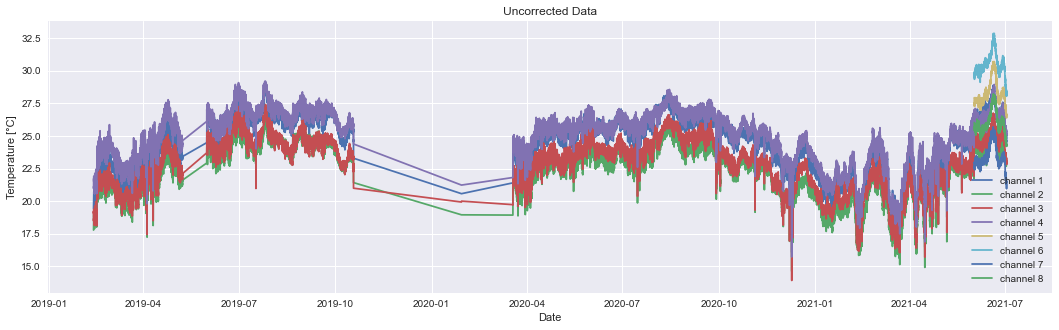

In [6]:
#plot data
length=15 # you can change it

plt.figure(figsize=(18,5))
for c in ["1","2","3","4","5","6","7","8"]:
    inde=data_all[c][length].index
    val=data_all[c][length].values
    plt.plot(inde,val, label=f"channel {c}")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.title("Uncorrected Data")
plt.legend(loc="lower right") # with large amount of data loc="best" can be slow

# Measurements per day calculation
To-Do - alles nicht so wichtig
* Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt
    * evntl markante Datenpunkte mithilfe von (rotem) Punkt markieren und label / patch dran machen

In [7]:
# Functions which I normally have in my_func_mvw.functions
def get_abspath(basepath):
    """Get the files you need to import into your script with Path
    Returns a list of all filepaths (or folderpaths) of the files (or folders) in a repository.
    The repository is given this function with basepath.

    you need to import: import glob
    """
    df_list = []
    basepath = glob.glob(basepath)
    for entry in basepath:
        df_list.append(entry)
    return (df_list)


In [8]:
#count the number of measurements per day; at the moment missing days are not printed

print("data 2019")
n_meas_pday_2019 = calculate_measurements_per_day(data_2019)

print();print();print("data 2020")
n_meas_pday_2020 = calculate_measurements_per_day(data_2020)

print();print();print("data 2021")
n_meas_pday_2021 = calculate_measurements_per_day(data_2021)

data 2019


data 2020


data 2021


In [9]:
# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in th new dictionaries

n_meas_pday_2019_with0=improve_n_meas_pday(n_meas_pday_2019, 2019)
n_meas_pday_2020_with0=improve_n_meas_pday(n_meas_pday_2020, 2020)
n_meas_pday_2021_with0=improve_n_meas_pday(n_meas_pday_2021, 2021)

In [10]:
# Calculate mean measurements per day per channel
def calc_mean_channels_n_pday(n_meas_pday_20xx_with0):
    """calculate the number of measurements as mean over the 4 channels"""
    channels=["1","2","3","4","5","6","7","8"]
    val={}
    date={}
    for channel in channels:
        val[channel]=np.array(list(n_meas_pday_20xx_with0[channel].values()))
        date[channel]=pd.to_datetime(list(n_meas_pday_20xx_with0["1"]))

    #mean measurements per day
    mean=(val["1"]+val["2"]+val["3"]+val["4"]+val["5"]+val["6"]+val["7"]+val["8"])/8

    # check if dates are equal
    counter_equal=0
    counter_not_equal=0
    for i in range(len(date["1"])):
        if date["1"][i] == date["2"][i] and date["3"][i] and date["4"][i] and date["5"][i] and date["6"][i] and date["7"][i] and date["8"][i]:
            #print("all dates for mean calculation are equal")
            counter_equal+=1
    else:
        #print("dates for mean calculation are not equal!")
        #print(date_ch1[i]);print(date_ch2[i]);print(date_ch3[i]);print(date_ch4[i])
        counter_not_equal+=1
    if counter_not_equal >= 3: # 31.12. seems to be a problem? Dont know why. Not very important.
        print("check dates")

    #all dates are equal, so I can just return one date
    return mean, date["1"]

mean_2019, date_2019 = calc_mean_channels_n_pday(n_meas_pday_2019_with0)
mean_2020, date_2020 = calc_mean_channels_n_pday(n_meas_pday_2020_with0)
mean_2021, date_2021 = calc_mean_channels_n_pday(n_meas_pday_2021_with0)

# Plot Measurements per day

In [11]:
def plot_save_func(filename_save):
    """saves the plots as png and copies them to my_database"""
    save_path = "pictures/" + filename_save + ".png"
    save_path_dpi720 = "pictures/dpi720/" + filename_save + "_dpi_720.png"
    plt.savefig(save_path)
    plt.savefig(save_path_dpi720, dpi=720)
    # copy pictures to my_database
    save_to = r"..\Alsdorf\Daten\my_database\overview_plots"
    save_to_dpi720 = r"..\Alsdorf\Daten\my_database\overview_plots\dpi720"
    copy_file(save_path, save_to)
    copy_file(save_path_dpi720, save_to_dpi720)

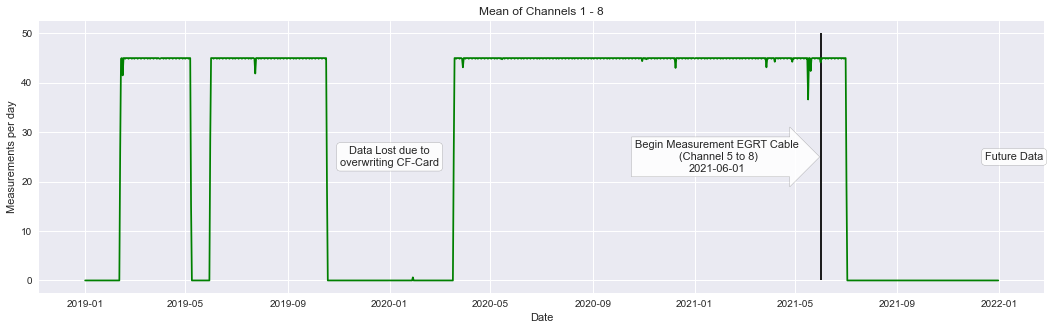

In [12]:
#Plot mean measurements per channel
plt.style.use("seaborn")

plt.figure(figsize=[18,5])
plt.plot(date_2019, mean_2019,color="green")
plt.plot(date_2020, mean_2020,color="green")
plt.plot(date_2021, mean_2021,color="green")
plt.ylabel("Measurements per day")
plt.xlabel("Date")
plt.title(f"Mean of Channels 1 - 8")

# PLOT ACCESSOIREs, Plot Patches with description
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=25; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
plt.text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# p is index of last date with 0 data from behind
p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=200)))
plt.text(x, y,"Future Data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box
# Add Patch at begin of measurement of EGRT cable (channel 5-8)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
ymax=max(np.concatenate([mean_2019,mean_2020,mean_2021])) + 5
plt.vlines(x, ymin=0, ymax=ymax, colors="black",linestyles="-")
bbox_props = dict(boxstyle="rarrow", fc="w", ec="0.5", alpha=0.9)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=125)) 
plt.text(x, y,"Begin Measurement EGRT Cable\n (Channel 5 to 8)\n2021-06-01", ha=ha, va=va, size=size, bbox=bbox_props)
# Add txt for dates of data gaps

if plot_save:
    plot_save_func("mean_of_all_channels_measpday")

plt.show()

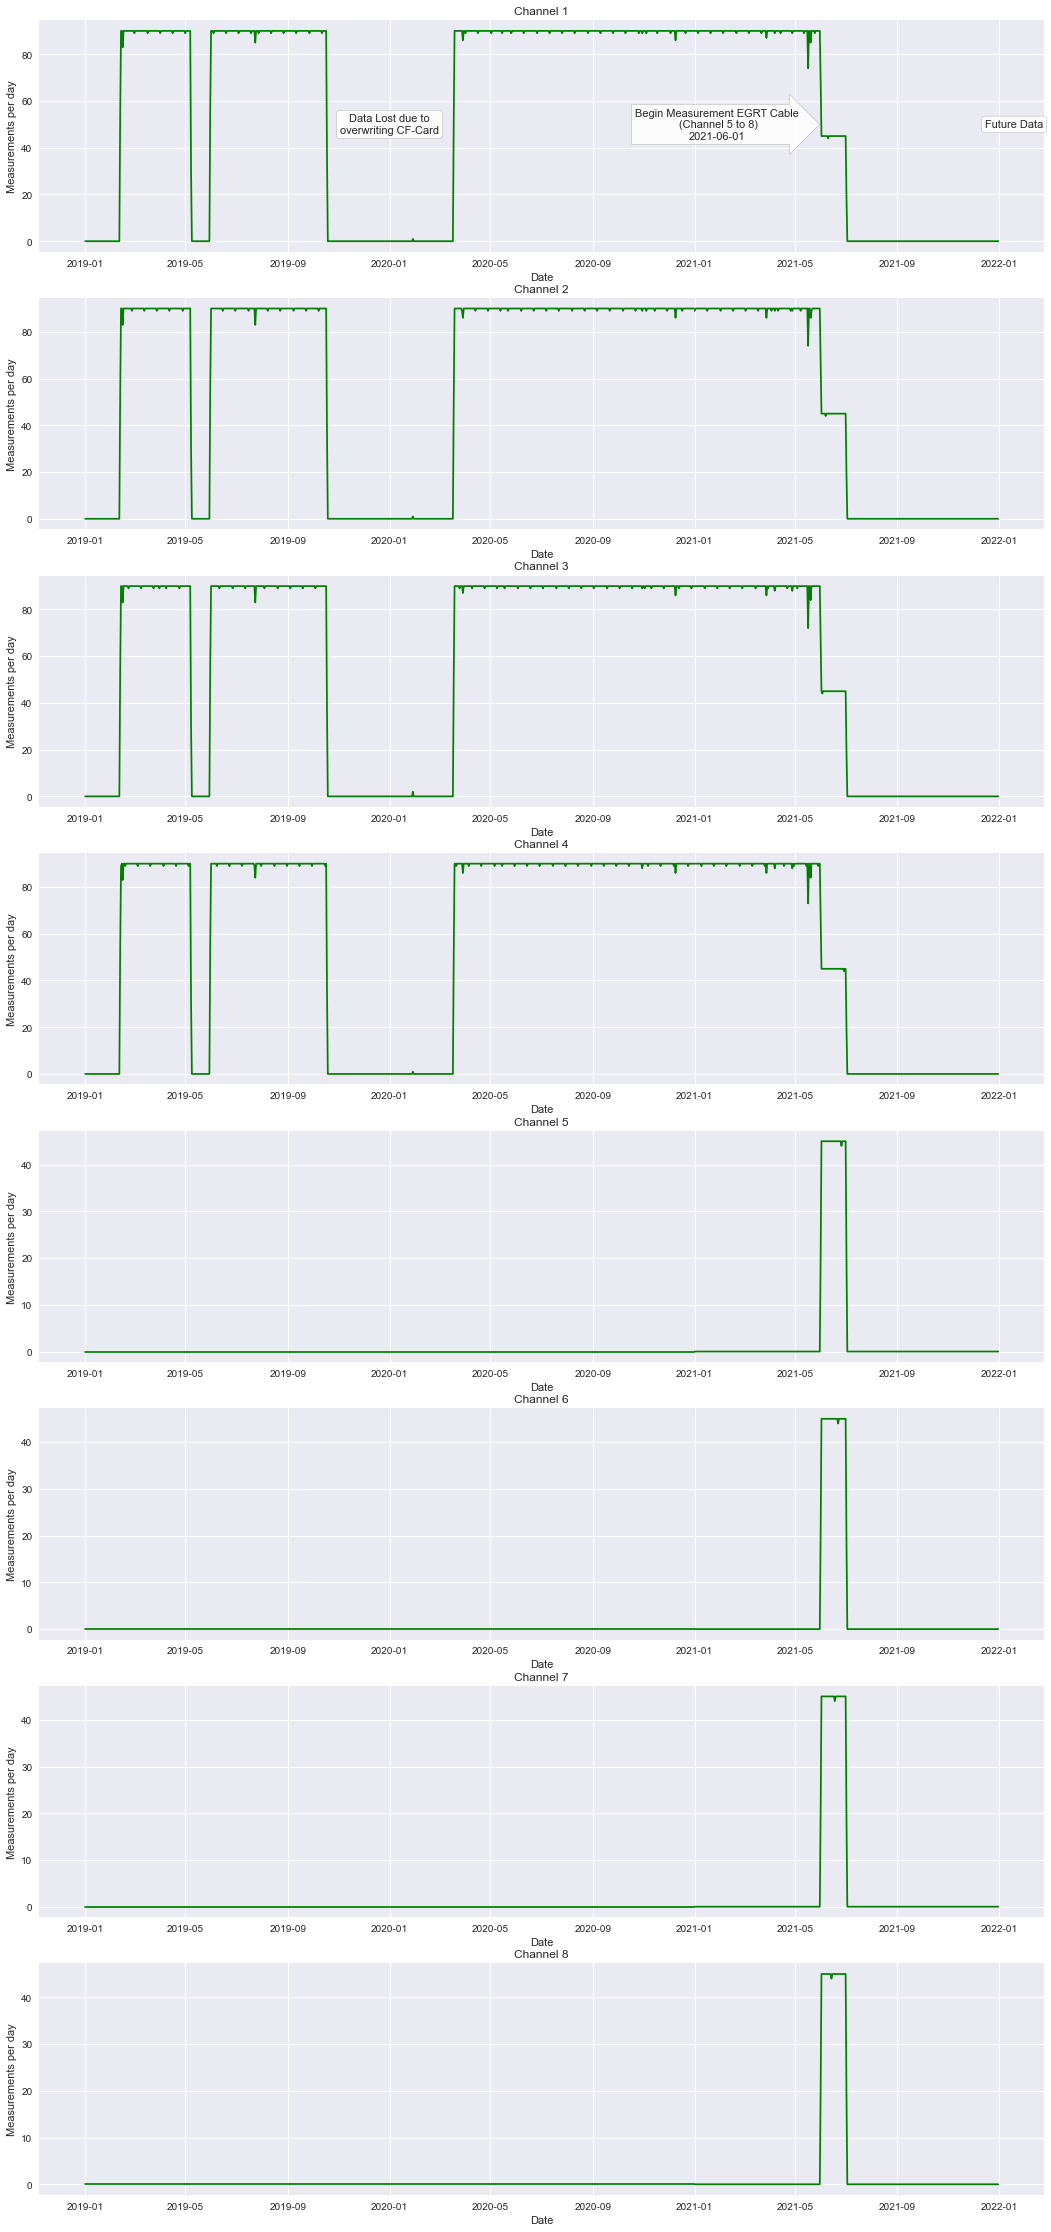

In [13]:
# Plot each channel seperate
#from cycler import cycler

# when plotting all different channels in one plot using a loop, this cycler is handy
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))
fig,axs=plt.subplots(8,1,figsize=[18,40])
for channel in ["1","2","3","4","5","6","7","8"]:
    n=int(channel)-1
    c="green"
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2019_with0[channel])), n_meas_pday_2019_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2020_with0[channel])), n_meas_pday_2020_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2021_with0[channel])), n_meas_pday_2021_with0[channel].values(),color=c)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))

# PLOT ACCESSOIREs, Plot Patches with description - copied from mean plot
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
axs[0].text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# p is index of last date with 0 data from behind
p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=200)))
axs[0].text(x, y,"Future Data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box
# Add Patch at begin of measurement of EGRT cable (channel 5-8)
#x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
bbox_props = dict(boxstyle="rarrow", fc="w", ec="0.5", alpha=0.9)
x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=125)) 
axs[0].text(x, y,"Begin Measurement EGRT Cable\n (Channel 5 to 8)\n2021-06-01", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    plot_save_func("all_channels_measpday")
    
plt.show()

# 90 Messungen pro Tag pro Channel is maximum: 24*60*60/45/8 = 240 s Mittelungszeitraum einer Messung
# 24*60*60: Sekunden pro Tag
# 45: Messungen pro Tag
# 8: Channel in denen gemessen wird

# 2018 data measurements per day plots

In [14]:
# difference to other years:
# different cable length exists --> they have there own key in dic
# column names are not int; due to sampling interval of 0.5 m in some cable length

# count meas per day variables for 2018
n_meas_pday_2018={}
n_meas_pday_2018_with0={}
for cable_type in data_2018.keys():
    n_meas_pday_2018[cable_type]      = calculate_measurements_per_day(data_2018[cable_type])
    n_meas_pday_2018_with0[cable_type] = improve_n_meas_pday(n_meas_pday_2018[cable_type], year=2018)


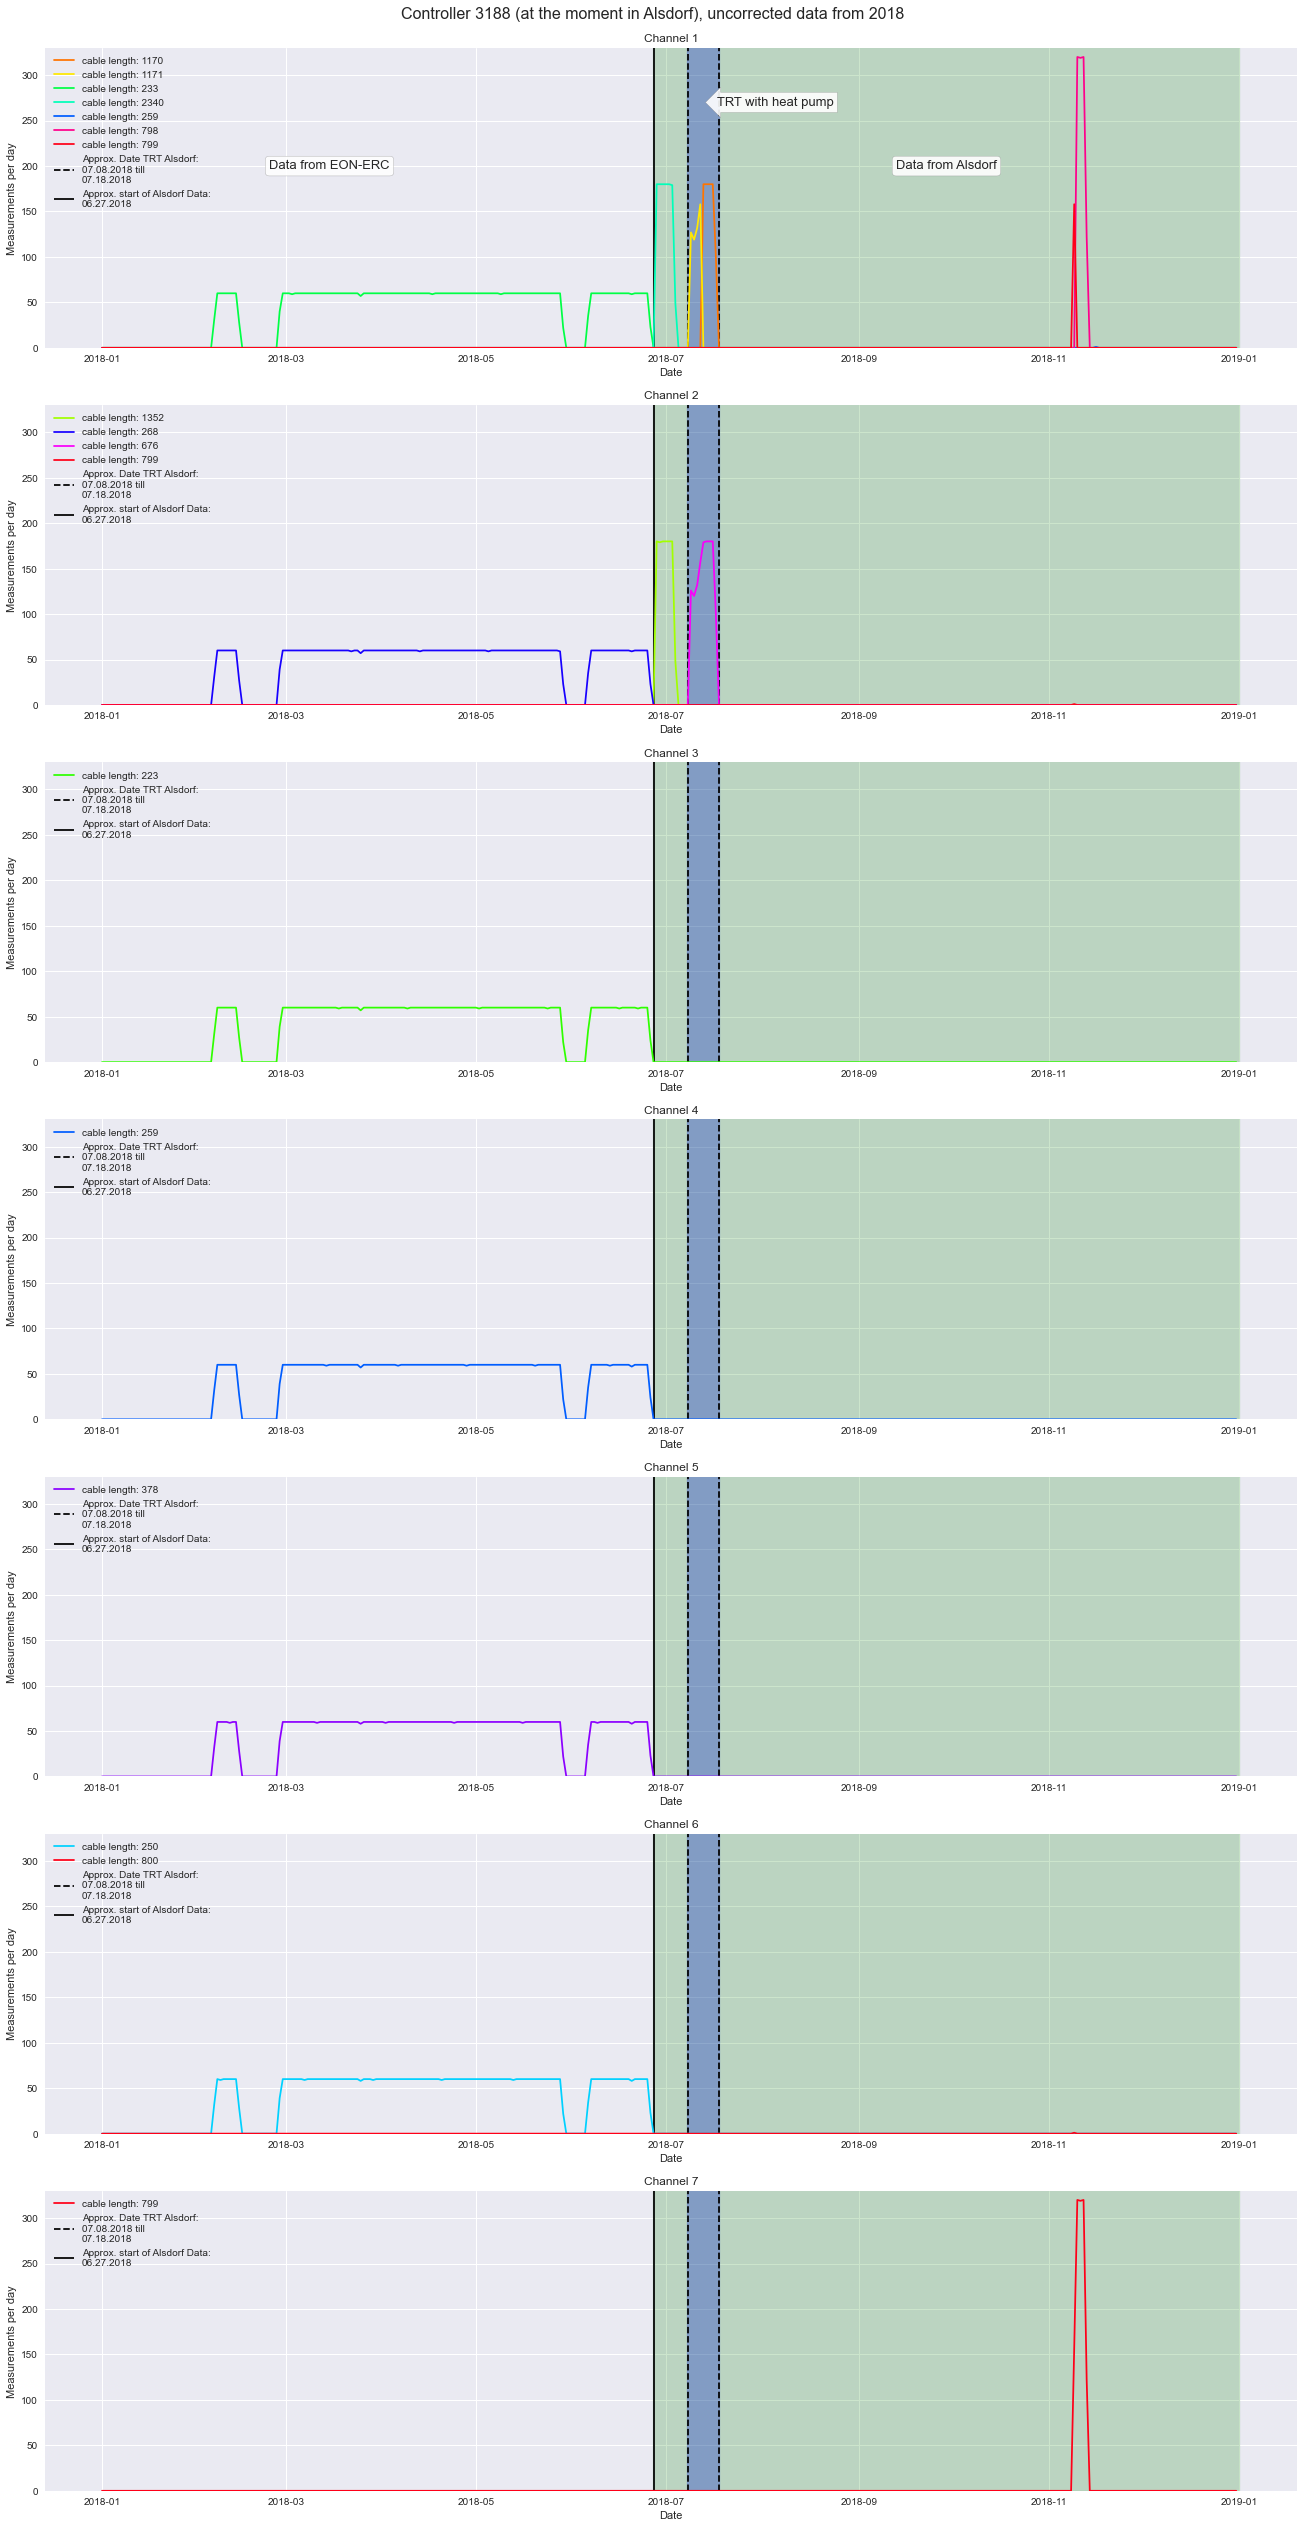

Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m
Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)
All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018


In [15]:
# Plot 2018 data
# Plot each channel seperate

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

fig,axs=plt.subplots(7,1,figsize=[18,35],constrained_layout=True)
fig.suptitle("Controller 3188 (at the moment in Alsdorf), uncorrected data from 2018", fontsize=16)
c=get_cmap(len(data_2018.keys())) # number of different cable lengths
for channel in ["1","2","3","4","5","6","7"]:
    n=int(channel)-1

    axs[n].set_ylim(0,330)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")

    # PLOT ACCESSOIREs
    # Plot date of TRT 9-10 Juli 2018, these somehow mark the first measurements in Alsdorf (info from Norbert)
    s_dat_trt="07.08.2018"
    e_dat_trt="07.18.2018"
    start_time_trt=mdates.date2num(pd.to_datetime(s_dat_trt))
    end_time_trt=mdates.date2num(pd.to_datetime(e_dat_trt))
    width_trt= end_time_trt - start_time_trt
    fancy_box=patches.FancyBboxPatch(xy=[start_time_trt,0],width=width_trt,height=350,color="blue",alpha=0.3,boxstyle='square')
    axs[n].add_patch(fancy_box)
    axs[n].vlines(start_time_trt, ymin=0, ymax=330, label=f"Approx. Date TRT Alsdorf:\n{s_dat_trt} till\n{e_dat_trt}", colors="black",linestyles="--")
    axs[n].vlines(end_time_trt, ymin=0, ymax=330, colors="black",linestyles="--")
    # Plot Approximated beginn of Alsdorf Data
    s_dat_als="06.27.2018"
    start_time_alsd=mdates.date2num(pd.to_datetime(s_dat_als))
    end_time_alsd=mdates.date2num(pd.to_datetime("01.01.2019"))
    width_alsd = end_time_alsd - start_time_alsd
    axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label=f"Approx. start of Alsdorf Data:\n{s_dat_als}", colors="black",linestyles="-")
    fancy_box=patches.FancyBboxPatch(xy=[start_time_alsd,0],width=width_alsd,height=350,color="green",alpha=0.2,boxstyle='square')
    axs[n].add_patch(fancy_box)

    # PLOT MEASUREMENTS PER DAY OF DATA
    counter=0
    for cable_type in data_2018.keys():
        counter+=1
        # only plot data which have at least one measurement
        if max(n_meas_pday_2018_with0[cable_type][channel].values()) > 0: 
            axs[n].plot(pd.to_datetime(list(n_meas_pday_2018_with0[cable_type][channel])), n_meas_pday_2018_with0[cable_type][channel].values(), color=c(counter), label=f"cable length: {cable_type}")
    
    axs[n].legend()

# Plot Patches only in first axes
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=13; y=200; ha="center"; va="center"
# Plot data which is expected to be from EON-ERC
start_time_eon=mdates.date2num(pd.to_datetime("12.01.2017"))
width_eon=start_time_alsd - start_time_eon
x = start_time_eon + 0.5 * width_eon
axs[0].text(x, y,"Data from EON-ERC", ha=ha, va=va, size=size, bbox=bbox_props)
x = start_time_alsd + 0.5 * width_alsd
axs[0].text(x, y,"Data from Alsdorf", ha=ha, va=va, size=size, bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
x = end_time_trt + 1.8* width_trt
axs[0].text(x, 270,f"TRT with heat pump", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    plot_save_func("all_channels_measpday_2018")
    
plt.show()


print("Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m")
print("Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)")
print("All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018")

# Checks
## To-DO
* [ ] check if pickle and csv data are perfectly equal (also regarding the format)
* [ ] Check if cable length changes 
* [ ] take a closer look at 2018 data

In [16]:
%%time
# Wall time: 1min 49s
# Data Check
# Check number of nan
# Channel 3 contains nan values at one length
if check == True:
    # number of nan
    for channel in data_all.keys():
        for column in data_all[channel].columns:
            n_nan=sum(data_all[channel][column].isna()) # number of nan in column
            if n_nan > 0:
                isna=data_all[channel][column].isna() # column with nan
                dates_isna=isna[isna == True].index
                print(f"number of nan values in channel {channel} at length {column}: {n_nan}")
                print("at the following dates:")
                print(dates_isna)
                print()


Wall time: 0 ns
